In [3]:
# %matplotlib widget

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pathlib import Path
from tqdm import tqdm
from typing import Dict, Tuple

from darts.metrics import rmse, mae
import warnings
warnings.filterwarnings('ignore')

In [4]:
def split_data_into_parts(data: pd.DataFrame, parts: int = 15) -> Dict[str, pd.DataFrame]:
    # Split data into parts
    chunk_size = len(data) // parts
    return {f"{idx+1}": data.iloc[idx * chunk_size:(idx + 1) * chunk_size] for idx in range(parts)}

def load_data(data_dir: str) -> Tuple[Dict, Dict]:
    data_path = Path(data_dir)
    all_data = {}

    # Find all parquet files
    parquet_files = list(data_path.glob("**/df*.parquet"))
    print(f"Found {len(parquet_files)} parquet files")

    for file_path in tqdm(parquet_files, desc="Processing cells", unit="cell"):
        # Extract cell number from parent directory name
        file_name = file_path.stem  
        cell_number = file_name.replace('df_', '')  
        cell_name = f'C{cell_number}'  
        tqdm.write(f"Processing {cell_name} ...")
            
        # Load and process data
        data = pd.read_parquet(file_path)
        data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] = pd.to_datetime(data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
        
        # Select relevant columns
        data = data[['Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'Current[A]', 'Voltage[V]', 
                    'Temperature[°C]', 'SOH_ZHU']]
        
        # Resample to hourly
        data.set_index('Absolute_Time[yyyy-mm-dd hh:mm:ss]', inplace=True)
        data_hourly = data.resample('h').mean().reset_index()
        
        # Fill missing values
        data_hourly.interpolate(method='linear', inplace=True)
        data_hourly['SOH_ZHU'] = data_hourly['SOH_ZHU'].fillna(1)
        
        # Convert to time series for full data
        target_series_full = TimeSeries.from_dataframe(data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'SOH_ZHU')
        covariates_full = TimeSeries.from_dataframe(data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', ['Current[A]', 'Voltage[V]', 'Temperature[°C]'])
        target_series_full, covariates_full = target_series_full.slice_intersect(covariates_full), covariates_full.slice_intersect(target_series_full)
        scaler_full = Scaler(scaler=MinMaxScaler(feature_range=(-1,1)))
        covariates_scaled_full = scaler_full.fit_transform(covariates_full)
        
        all_data[cell_name] = {'target': target_series_full, 'covariates_scaled': covariates_scaled_full, 'df': data_hourly }

    return all_data

data_dir = "../01_Datenaufbereitung/Output/Calculated/"
all_data = load_data(data_dir)

Found 15 parquet files


Processing cells:   0%|          | 0/15 [00:00<?, ?cell/s]

Processing C01 ...


Processing cells:   7%|▋         | 1/15 [00:10<02:25, 10.40s/cell]

Processing C03 ...


Processing cells:  13%|█▎        | 2/15 [00:17<01:48,  8.33s/cell]

Processing C05 ...


Processing cells:  20%|██        | 3/15 [00:24<01:33,  7.75s/cell]

Processing C07 ...


Processing cells:  27%|██▋       | 4/15 [00:30<01:18,  7.18s/cell]

Processing C09 ...


Processing cells:  33%|███▎      | 5/15 [00:34<00:58,  5.85s/cell]

Processing C11 ...


Processing cells:  40%|████      | 6/15 [00:37<00:45,  5.09s/cell]

Processing C13 ...


Processing cells:  47%|████▋     | 7/15 [00:39<00:31,  3.95s/cell]

Processing C15 ...


Processing cells:  53%|█████▎    | 8/15 [00:41<00:22,  3.27s/cell]

Processing C17 ...


Processing cells:  60%|██████    | 9/15 [00:47<00:24,  4.16s/cell]

Processing C19 ...


Processing cells:  67%|██████▋   | 10/15 [00:52<00:22,  4.58s/cell]

Processing C21 ...


Processing cells:  73%|███████▎  | 11/15 [01:00<00:21,  5.43s/cell]

Processing C23 ...


Processing cells:  80%|████████  | 12/15 [01:05<00:16,  5.55s/cell]

Processing C25 ...


Processing cells:  87%|████████▋ | 13/15 [01:10<00:10,  5.09s/cell]

Processing C27 ...


Processing cells:  93%|█████████▎| 14/15 [01:15<00:05,  5.24s/cell]

Processing C29 ...


Processing cells: 100%|██████████| 15/15 [01:19<00:00,  5.32s/cell]


In [5]:
def inspect_data_ranges(data_dict: dict):
   """
   Inspect time ranges and value ranges for each battery in the data dictionary
   """
   for cell_name, cell_data in data_dict.items():
       print(f"\n=== {cell_name} ===")
       
       # Get target data range
       target = cell_data['target']
       target_values = target.values().flatten()  # Flatten array for calculation
       print("\nTarget (SOH_ZHU):")
       print(f"Time Range: {target.start_time()} to {target.end_time()}")
       print(f"Value Range: {target_values.min():.4f} to {target_values.max():.4f}")
       print(f"Number of Data Points: {len(target)}")
       
       # Get covariates data range
       covariates = cell_data['covariates_scaled']
       cov_values = covariates.values()
       print("\nCovariates (scaled):")
       for i, feature in enumerate(covariates.components):
           values = cov_values[:, i].flatten()
           print(f"{feature}:")
           print(f"Value Range: {values.min():.4f} to {values.max():.4f}")

# View all data ranges
print("All Data Ranges:")
inspect_data_ranges(all_data)

All Data Ranges:

=== C01 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-09-16 07:00:00
Value Range: 0.9225 to 1.0000
Number of Data Points: 5423

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C03 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-17 10:00:00
Value Range: 0.9206 to 1.0000
Number of Data Points: 4706

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C05 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-13 12:00:00
Value Range: 0.9172 to 1.0000
Number of Data Points: 4612

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C07 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-13 14

In [6]:
def split_cell_data(all_data: dict, train=13, val=1, test=1, parts=15) -> Tuple[Dict, Dict, Dict]:
    """Splits the dataset into training, validation, and test sets, then further divides train and val into parts."""
    
    cell_names = list(all_data.keys())
    np.random.seed(773)
    np.random.shuffle(cell_names)

    # 1. **Split data at the cell level into train/val/test sets**
    train_cells = cell_names[:train]
    val_cells = cell_names[train:train + val]
    test_cells = cell_names[train + val:train + val + test]

    print(f"Cell split completed:")
    print(f"Training set: {len(train_cells)} cells")
    print(f"Validation set: {len(val_cells)} cells")
    print(f"Test set: {len(test_cells)} cells")

    train_parts = []
    val_parts = []

    # 2. **Split training data into smaller parts**
    for cell in train_cells:
        split_data = split_data_into_parts(all_data[cell]['df'], parts=parts)
        for part_idx, df_part in split_data.items():
            part_name = f"{cell}_{part_idx}"
            target_series_part = TimeSeries.from_dataframe(df_part, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'SOH_ZHU')
            covariates_part = TimeSeries.from_dataframe(df_part, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', ['Current[A]', 'Voltage[V]', 'Temperature[°C]'])
            target_series_part, covariates_part = target_series_part.slice_intersect(covariates_part), covariates_part.slice_intersect(target_series_part)
            scaler_part = Scaler(scaler=MinMaxScaler(feature_range=(-1,1)))
            covariates_scaled_part = scaler_part.fit_transform(covariates_part)
            train_parts.append((part_name, {'target': target_series_part, 'covariates_scaled': covariates_scaled_part}))

    # 3. **Split validation data into smaller parts**
    for cell in val_cells:
        split_data = split_data_into_parts(all_data[cell]['df'], parts=parts)
        for part_idx, df_part in split_data.items():
            part_name = f"{cell}_{part_idx}"
            target_series_part = TimeSeries.from_dataframe(df_part, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'SOH_ZHU')
            covariates_part = TimeSeries.from_dataframe(df_part, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', ['Current[A]', 'Voltage[V]', 'Temperature[°C]'])
            target_series_part, covariates_part = target_series_part.slice_intersect(covariates_part), covariates_part.slice_intersect(target_series_part)
            scaler_part = Scaler(scaler=MinMaxScaler(feature_range=(-1,1)))
            covariates_scaled_part = scaler_part.fit_transform(covariates_part)
            val_parts.append((part_name, {'target': target_series_part, 'covariates_scaled': covariates_scaled_part}))

    # 4. **Combine and shuffle train and validation parts**
    all_parts = train_parts + val_parts
    np.random.shuffle(all_parts)

    # 5. **Reassign train and validation parts**
    new_train_size = train * parts
    new_val_size = val * parts

    train_data = dict(all_parts[:new_train_size])
    val_data = dict(all_parts[new_train_size:new_train_size + new_val_size])

    # 6. **Keep test data as full cells without splitting**
    test_data = {cell: all_data[cell] for cell in test_cells}

    print(f"Data split completed:")
    print(f"Training set: {len(train_data)} parts")
    print(f"Validation set: {len(val_data)} parts")
    print(f"Test set: {len(test_data)} full cells")

    return train_data, val_data, test_data

# Execute data split
train_data, val_data, test_data = split_cell_data(all_data)

# Inspect training data
inspect_data_ranges(train_data)


Cell split completed:
Training set: 13 cells
Validation set: 1 cells
Test set: 1 cells
Data split completed:
Training set: 195 parts
Validation set: 15 parts
Test set: 1 full cells

=== C03_5 ===

Target (SOH_ZHU):
Time Range: 2023-03-26 13:00:00 to 2023-04-08 13:00:00
Value Range: 0.9690 to 0.9772
Number of Data Points: 313

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C09_3 ===

Target (SOH_ZHU):
Time Range: 2023-02-17 01:00:00 to 2023-02-24 08:00:00
Value Range: 0.9624 to 0.9805
Number of Data Points: 176

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C11_8 ===

Target (SOH_ZHU):
Time Range: 2023-04-02 14:00:00 to 2023-04-11 00:00:00
Value Range: 0.8420 to 0.8888
Number of Data Points: 203

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Volt

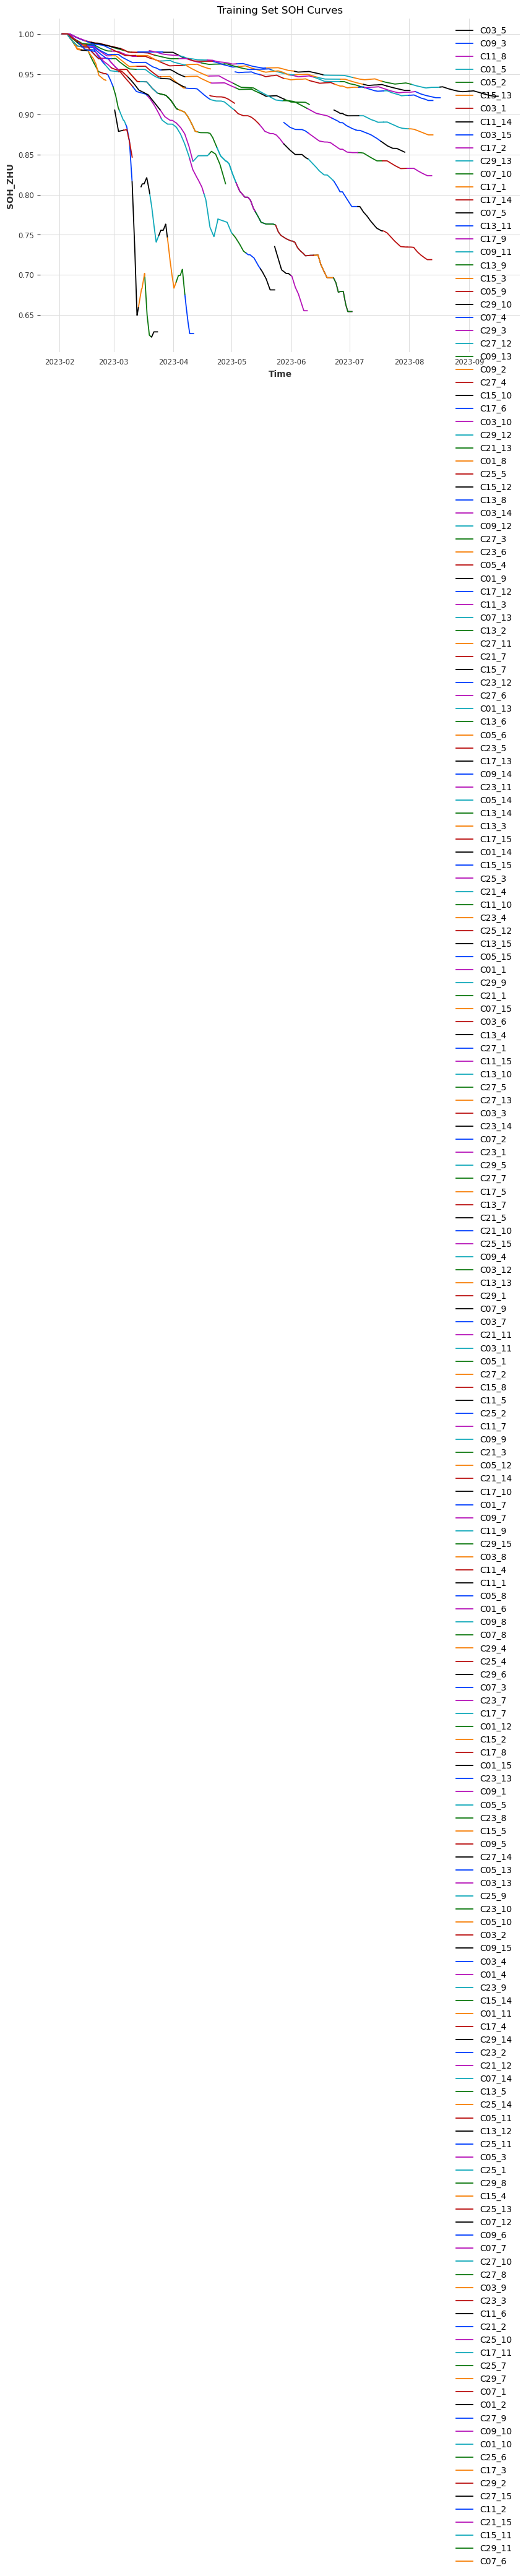

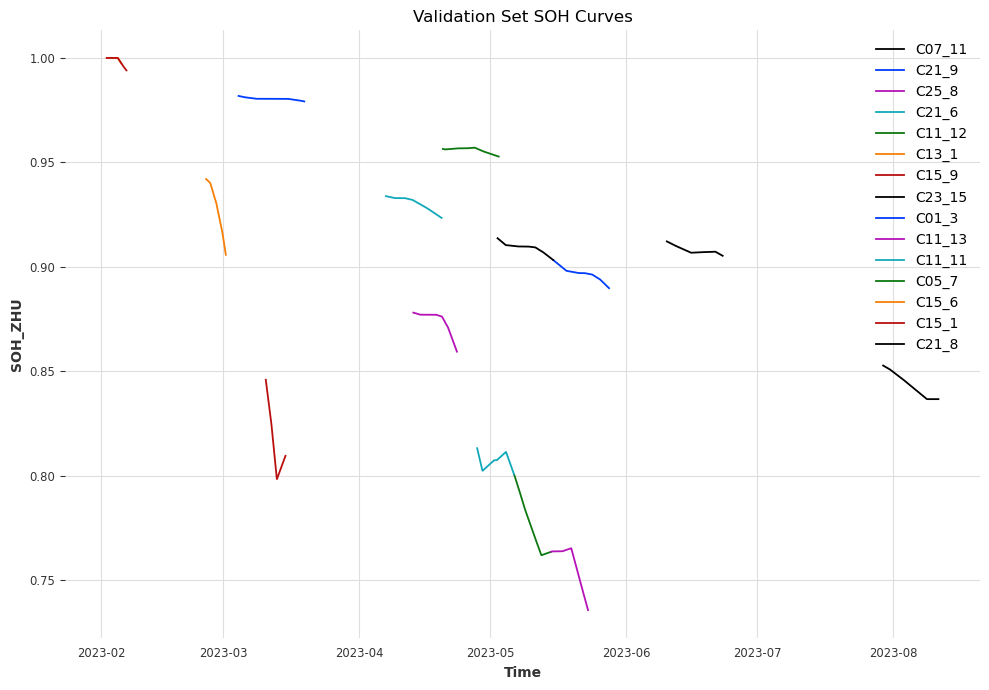

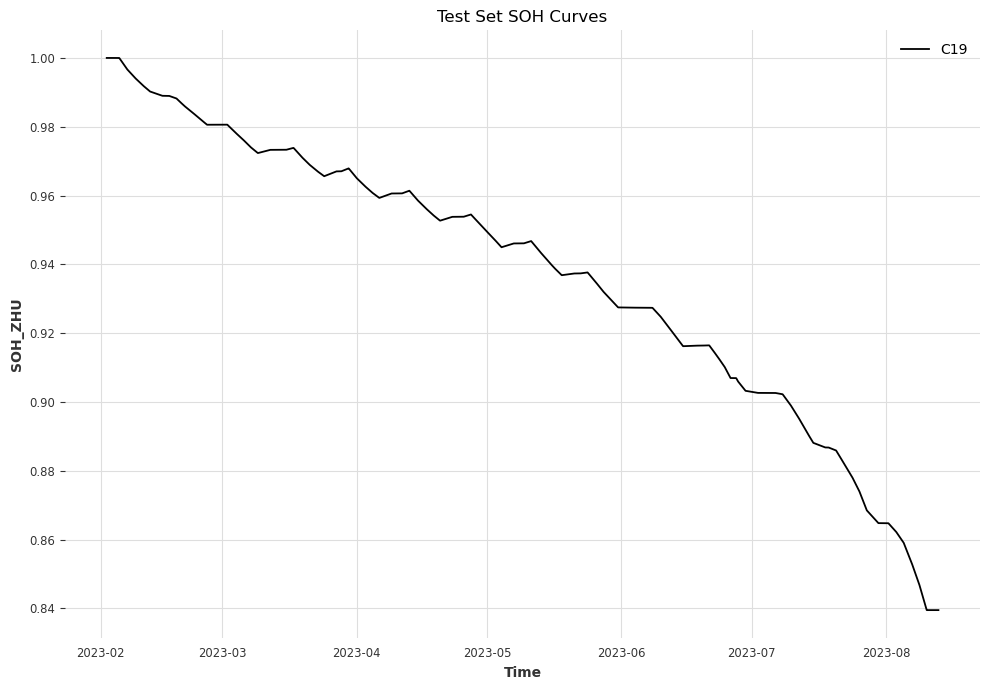

In [7]:
def plot_dataset_soh(data_dict: dict, title: str, figsize=(10, 7)):
    plt.figure(figsize=figsize)
    
    # Plot each cell's SOH
    for cell_name, cell_data in data_dict.items():
        target = cell_data['target']
        plt.plot(target.time_index, target.values().flatten(), label=cell_name)
    
    plt.title(f'{title} Set SOH Curves')
    plt.xlabel('Time')
    plt.ylabel('SOH_ZHU')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Plot all three datasets
plot_dataset_soh(train_data, "Training")
plot_dataset_soh(val_data, "Validation")
plot_dataset_soh(test_data, "Test")

In [8]:
def prepare_data(data):
    targets = []
    covariates = []
    for cell_data in data.values():
        targets.append(cell_data['target'])
        covariates.append(cell_data['covariates_scaled'])
    
    series = targets[0]
    cov = covariates[0]
    for i in range(1, len(targets)):
        series = series.concatenate(targets[i], ignore_time_axis=True)
        cov = cov.concatenate(covariates[i], ignore_time_axis=True)
    return series, cov

In [12]:
best_params = {'input_chunk_length': 33, 
               'output_chunk_length': 1, 
               'num_blocks': 4, 
               'num_stacks': 3, 
               'activation': 'LeakyReLU', 
               'batch_size': 32, 
               "expansion_coefficient_dim":16,
               "trend_polynomial_degree":2
               }

best_model = NBEATSModel(
    input_chunk_length=best_params["input_chunk_length"],
    output_chunk_length=best_params["output_chunk_length"],
    num_blocks=best_params["num_blocks"],
    num_stacks=best_params["num_stacks"],
    batch_size=best_params["batch_size"],
    expansion_coefficient_dim=best_params["expansion_coefficient_dim"],  
    trend_polynomial_degree=best_params["trend_polynomial_degree"],  
    random_state=773,  
    activation=best_params["activation"],
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": 1,
        "callbacks": [
            ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1),
            EarlyStopping(monitor="val_loss", patience=60, mode="min", verbose=True),  
            ],
        "enable_checkpointing": True
    },
    lr_scheduler_cls=ReduceLROnPlateau,
)


# Prepare data for training
train_series, train_cov = prepare_data(train_data)
val_series, val_cov = prepare_data(val_data)

best_model.fit(series=train_series, past_covariates=train_cov, 
               val_series=val_series, val_past_covariates=val_cov, epochs=500, verbose=True)

best_model.save('best_nbeats_model')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 2.9 M  | train
-------------------------------------------------------------
2.9 M     Trainable params
6.4 K     Non-trainable params
2.9 M     Total params
11.614    Total estimated model params size (MB)
144       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.000


Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
def prepare_test_data(data):
    series = []
    cov = []
    for cell_data in data.values():
        series.append(cell_data['target'])
        cov.append(cell_data['covariates_scaled'])
    return series, cov


def prdictions(model_path:str, test_data):
    model = NBEATSModel.load(model_path)

    test_series, test_cov = [], []
    for cell_data in test_data.values():
        test_series.append(cell_data['target'])
        test_cov.append(cell_data['covariates_scaled'])
        
    start = model.input_chunk_length + model.output_chunk_length
    pred_test = model.historical_forecasts(
        series=test_series,
        past_covariates=test_cov,
        start=start,
        forecast_horizon=model.output_chunk_length,
        retrain=False,
        verbose=True
    )

    backtest_rmse = rmse(test_series, pred_test)
    backtest_mae = mae(test_series, pred_test)
    print(f'Backtest RMSE of Testdaten = {backtest_rmse}')
    print(f'Backtest MAE of Testdaten = {backtest_rmse}')
    
    cell_ids = test_data.keys()  

    plt.figure(figsize=(12, 6))
    for i, (cell_id, pred) in enumerate(zip(cell_ids, pred_test)):
        pred.plot(label=f'{cell_id} Forecast', 
                    linestyle='--')
    
        test_data[cell_id]['target'].plot(label=f'{cell_id} Actual', 
                                            linestyle='-',
                                            alpha=0.7)

    ax = plt.gca()
    ax.text(0.5, 1.0, f'Backtest RMSE {backtest_rmse}\nBacktest MAE: {backtest_mae}', transform=ax.transAxes, fontsize=12, ha='center', va='top')

    plt.title("SOH Forecast vs Actual") 
    plt.xlabel("Time")
    plt.ylabel("SOH")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

model_path = r'best\02\train 500\best_nbeats_model'
# model_path = 'best_nbeats_model'

prdictions(model_path, test_data)
